In [37]:
# LIBRERIAS

import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

tf.config.list_physical_devices('GPU') 



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
# Lectura de ficheros con los datasets de las empresas a analizar

companies = {}
ficheros = os.listdir('data')

for file in ficheros:
    company = file[:-4]
    dfcompany = pd.read_csv(f"data/{file}")
    companies[company] = dfcompany




In [30]:
# Tomamos datos de amazon para pruebas con el modelo.
dfcompany = companies['AMZN']
dfcompany

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMZN,2017-04-24 00:00:00+00:00,907.41,909.990,903.8200,908.68,3118123,907.41,909.990,903.8200,908.68,3118123,0.0,1.0
1,AMZN,2017-04-25 00:00:00+00:00,907.62,909.480,903.0000,907.04,3367734,907.62,909.480,903.0000,907.04,3367734,0.0,1.0
2,AMZN,2017-04-26 00:00:00+00:00,909.29,915.749,907.5600,910.30,2562595,909.29,915.749,907.5600,910.30,2562595,0.0,1.0
3,AMZN,2017-04-27 00:00:00+00:00,918.38,921.860,912.1100,914.39,4255693,918.38,921.860,912.1100,914.39,4255693,0.0,1.0
4,AMZN,2017-04-28 00:00:00+00:00,924.99,949.590,924.3335,948.83,7278819,924.99,949.590,924.3335,948.83,7278819,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,AMZN,2022-04-14 00:00:00+00:00,3034.13,3117.940,3029.4350,3107.80,2579907,3034.13,3117.940,3029.4350,3107.80,2579907,0.0,1.0
1255,AMZN,2022-04-18 00:00:00+00:00,3055.70,3080.790,3005.0100,3030.47,2325676,3055.70,3080.790,3005.0100,3030.47,2325676,0.0,1.0
1256,AMZN,2022-04-19 00:00:00+00:00,3162.31,3172.980,3031.0100,3040.59,2746321,3162.31,3172.980,3031.0100,3040.59,2746321,0.0,1.0
1257,AMZN,2022-04-20 00:00:00+00:00,3079.96,3152.050,3072.0700,3152.05,2958600,3079.96,3152.050,3072.0700,3152.05,2958600,0.0,1.0


In [31]:
# Crreación de una matriz de datos de para la red neuronal
def create_dataset(dataset, look_back):
	x_data, y_data = [], []
	for i in range(len(dataset)-look_back-1):
		x = dataset[i:(i+look_back), 0]
		x_data.append(x)
		y = dataset[i + look_back, 0]
		y_data.append(y)
        
	return np.array(x_data), np.array(y_data)

def graficar(dfcompany, company):
	plt.plot(dfcompany)
	plt.xlabel('Days')
	plt.ylabel('Price')
	plt.title(label=company)

# Graficar el resultado
def graficarResultado(dfcompany, look_back, train_predict, test_predict):
    # Ajustamos los datos para mostrar la predicción
    trainPredictPlot = np.empty_like(dfcompany)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(dfcompany)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfcompany)-1, :] = test_predict

    # Mostrar las los datos originales y la predicción
    plt.plot(scaler.inverse_transform(dfcompany), label='Original data')
    plt.plot(trainPredictPlot, label='Train prediction')
    plt.plot(testPredictPlot, label='Test prediction')
    plt.legend()
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
	
#Separar datos de entrenamiento y test
def split(dfcompany, look_back, percent=70):
    training_size = int(len(dfcompany)*percent) 
    test_size = len(dfcompany)-training_size 

    train_data, test_data = dfcompany[0:training_size,:], dfcompany[training_size:len(dfcompany),:1]


    #Creamos la matrix para los datos de entrenamiento y test    
    X_train, y_train = create_dataset(train_data, look_back) #(,) (,)
    X_test, y_test = create_dataset(test_data, look_back) #(,) (,)
    #print(f"La matriz X_train tiene la forma: {X_train.shape}")
    #print(f"La matriz y_train tiene la forma: {y_train.shape}")
    #print(f"La matriz X_test tiene la forma: {X_test.shape}")
    #print(f"La matriz y_test tiene la forma: {y_test.shape}")
    

    # Hay que hacer reshape a las entradas de la red LSTM añadiendo 1 dimension [samples, look_back, features]
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


    return X_train, X_test, y_train, y_test



In [32]:
def create_model(look_back, nneuronas=50, epochs=50):
    model=Sequential()
    #Capa 1
    #model.add(LSTM(nneuronas, return_sequences=True, input_shape=(look_back,1)))
    model.add(LSTM(nneuronas, input_shape=(look_back,1)))

    #Capa 2
    #model.add(LSTM(nneuronas, return_sequences=True))
    
    # Capa 2
    #model.add(LSTM(nneuronas))
        
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    #model.summary()

    return model

In [33]:
def prediccion (model, X_train, X_test, y_train, y_test, look_back):
    # Realizar predicción sobre datos de entranamiento y test
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transformamos los datos a su escala original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    return  train_predict, test_predict

Epoch 1/200
17/17 [==============================] - 2s 56ms/step - loss: 0.0385 - val_loss: 0.0235
Epoch 2/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 3/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 5/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 6/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 7/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 8/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 9/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 10/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0032
Epoc

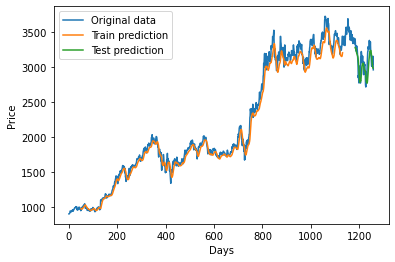

In [34]:
# Definimos cuantos días usará el modelo para predecir el día siguiente
look_back = 50

epochs = 200

nneuronas = 100

learning_rate = 



#Definimos Early Stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, min_delta=0.5)

for n in nneuronas:
    dfcompany = companies['AMZN']
    # Por cada empresa, preprocesar, entrenar y guardar resultados
    company = dfcompany.iloc[0,0]

    #graficar(dfcompany, company)

    # Descartamos todas las columnas y nos quedamos unicamente con el precio de cierre de la acción
    dfcompany = dfcompany.reset_index()['close']
    scaler=MinMaxScaler(feature_range=(0,1))
    dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
    X_train, X_test, y_train, y_test = split(dfcompany, look_back, percent=0.90)

    model = create_model(look_back, nneuronas=n, epochs = epochs)
    history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=64, verbose=1, callbacks=[es])  

    train_predict, test_predict = prediccion(model, X_train, X_test, y_train, y_test, look_back)

    # Calculamos el error en entrenamiento y test
    train_error = math.sqrt(mean_squared_error(y_train, train_predict))
    test_error = math.sqrt(mean_squared_error(y_test, test_predict))

    print(f"Para la empresa {company}")
    print(f"Con {n} neuronas, el error es:")
    print(f"Error entrenamiento: {train_error}")
    print(f"Error test: {test_error}")

    graficarResultado(dfcompany, look_back, train_predict, test_predict)



In [35]:

# Predicción del ultimo dia 
print(scaler.inverse_transform(y_test[24].reshape(-1,1)))
print(test_predict[24])

[[3158.71]]
[2834.9504]


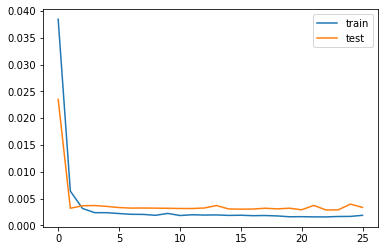

In [36]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()